In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [4]:
# define relative paths to image directories


# create image data generators to feed the model from image directories
target_size = (224, 224)
batch_size = 40
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=target_size, 
                                                         batch_size=batch_size)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, 
                                                         target_size=target_size, 
                                                         batch_size=batch_size)
test_batches = ImageDataGenerator().flow_from_directory(test_path, 
                                                        target_size=target_size,
                                                        batch_size=batch_size)

NameError: name 'train_path' is not defined

In [11]:
# import cleaned data
liver_df = pd.read_csv('indian_liver_dataset_clean.csv', index_col=0)
print(liver_df.info())

# convert sex and disease group variables to numeric form
liver_df.sex = liver_df.sex.map({'Male': 1, 'Female': 0})
liver_df['liver disease'] = liver_df['liver disease'].astype('int')
liver_df.head(10)

# convert sex, age, ALP, ALT, and AST to float64
liver_df.sex = liver_df.sex.astype(np.float64)
liver_df.age = liver_df.age.astype(np.float64)
liver_df.ALP = liver_df.ALP.astype(np.float64)
liver_df.ALT = liver_df.ALT.astype(np.float64)
liver_df.AST = liver_df.AST.astype(np.float64)
print(liver_df.info())
liver_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null int64
sex              583 non-null object
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null int64
ALT              583 non-null int64
AST              583 non-null int64
total protein    583 non-null float64
albumin          583 non-null float64
a-g ratio        583 non-null float64
liver disease    583 non-null bool
dtypes: bool(1), float64(5), int64(4), object(1)
memory usage: 50.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 582
Data columns (total 11 columns):
age              583 non-null float64
sex              583 non-null float64
total bili       583 non-null float64
direct bili      583 non-null float64
ALP              583 non-null float64
ALT              583 non-null float64
AST              583 non-null float64
total protein    583 non-null float64
alb

,age,sex,total bili,direct bili,ALP,ALT,AST,total protein,albumin,a-g ratio,liver disease
0,65.0,0.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1
1,62.0,1.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1
2,62.0,1.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1
3,58.0,1.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1
4,72.0,1.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1


In [12]:
# create train and test datasets
from sklearn.model_selection import train_test_split

X = liver_df.copy()
y = X.pop('liver disease')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=51)

In [51]:
# mean per-class recall is not available as default Keras metric
def as_keras_metric(method):
    '''
    Wraps tensorflow metric for use as custom keras metric 
    
    Source: https://stackoverflow.com/questions/43076609/
    how-to-calculate-precision-and-recall-in-keras
    '''
    import functools
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

def mpca(labels, predictions):
    '''
    Feeds num_classes manually into mpca, since keras does not do this natively
    '''
    return tf.metrics.mean_per_class_accuracy(labels, predictions, num_classes=2)

# mean per-class recall is equivalent to mean per-class accuracy
mean_recall = as_keras_metric(mpca)

In [7]:
def build_VGG16(width, new_weights=False, trainable=False):
    '''
    Builds a modified version of the VGG16 model for transfer learning
    
    Parameters:
    width(int) - number of nodes present in each of the two new FC layers after
        the convolutional layers
    new_weights(bool) - whether to reinitialize the weights in the VGG16
        convolutional layers
    trainable(bool) - whether to allow updating of convolutional weights
    
    Returns:
    Compiled keras functional API model object
    '''
    
    if new_weights == True:
        weights = None
    else:
        weights = 'imagenet'
    
    # import only the convolutional layers of VGG16
    base_model = VGG16(include_top=False, 
                       weights=weights, 
                       input_shape=(224, 224, 3))
    
    if trainable == False:
        for layer in base_model.layers:
            layer.trainable = False
    
    # add two FC layers to end of convolutional layers
    inputs = base_model.output
    x = Flatten()(inputs)
    x = Dense(width, activation='relu')(x)
    x = Dense(width, activation='relu')(x)
    preds = Dense(5, activation='softmax')(x)

    # compile model
    model = Model(inputs=base_model.inputs, outputs=preds)
    model.compile(optimizer=Adam(lr=0.0001, decay=0.1), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', mean_recall])
    
    return model

In [49]:
def build_FC(width):
    '''
    Builds a fully connected model with two layers
    
    Parameters:
    width(int) - number of nodes present in each of the two new FC layers after
        the convolutional layers
    
    Returns:
    Compiled keras model object
    '''
    
    # add two FC layers 
    model = Sequential()
    model.add(Dense(width, input_dim=10, activation='relu'))
    model.add(Dense(width, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(optimizer=Adam(lr=0.0001, decay=0.1), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', mean_recall])
    
    return model

In [52]:
def run_in_duplicate(width, new_weights=False, trainable=False):
    '''
    Runs two initialization and training passes for each model variation
    
    Returns the training history (mean recall for each epoch)
    '''
    
    # define callbacks for model fitting
    
    
    # build first model
    model_1 = build_VGG16(width, new_weights=new_weights, trainable=trainable)
    
    # fit the model to the training data
    history_1 = model.fit_generator(train_batches, 
                                    steps_per_epoch=9000/batch_size, 
                                    validation_data=valid_batches, 
                                    validation_steps=1000/batch_size, 
                                    epochs=20)
    
    # build second model
    model_2 = build_VGG16(width, new_weights=new_weights, trainable=trainable)
    
    # fit the model to the training data
    history_2 = model.fit_generator(train_batches, 
                                    steps_per_epoch=9000/batch_size, 
                                    validation_data=valid_batches, 
                                    validation_steps=1000/batch_size, 
                                    epochs=20)
    
    # determine average accuracy of the two runs
    acc_1 = np.array(history_1.history['acc'])
    acc_2 = np.array(history_2.history['acc'])
    acc = (acc_1 + acc_2)/2
    
    # determine average loss of the two runs
    loss_1 = np.array(history_1.history['loss'])
    loss_2 = np.array(history_2.history['loss'])
    loss = (loss_1 + loss_2)/2
    
    # determine average mpca of the two runs
    mpca_1 = np.array(history_1.history['mpca'])
    mpca_2 = np.array(history_2.history['mpca'])
    mpca = (mpca_1 + mpca_2)/2
    
    return {'acc': acc, 'loss':loss, 'mpca':mpca}

In [67]:
def run_in_duplicate(width):
    '''
    Runs two initialization and training passes for each model variation
    
    Returns the training history (mean recall for each epoch)
    '''
        
    # build first model
    model_1 = build_FC(width)
    
    # fit the model to the training data
    history_1 = model_1.fit(X_train, 
                          y_train,
                          epochs=20, 
                          verbose=0)
    
    # build second model
    model_2 = build_FC(width)
    
    # fit the model to the training data
    history_2 = model_2.fit(X_train, 
                          y_train,
                          epochs=20, 
                          verbose=0)
    
    # determine average accuracy of the two runs
    acc_1 = np.array(history_1.history['acc'])
    acc_2 = np.array(history_2.history['acc'])
    acc = (acc_1 + acc_2)/2
    
    # determine average loss of the two runs
    loss_1 = np.array(history_1.history['loss'])
    loss_2 = np.array(history_2.history['loss'])
    loss = (loss_1 + loss_2)/2
    
    # determine average mpca of the two runs
    mpca_1 = np.array(history_1.history['mpca'])
    mpca_2 = np.array(history_2.history['mpca'])
    mpca = (mpca_1 + mpca_2)/2
    
    return {'acc': acc, 'loss':loss, 'mpca':mpca}

In [68]:
# pretrained 100
pre_100_his = run_in_duplicate(100)


# pretrained 200
pre_200_his = run_in_duplicate(200)

# pretrained 300
pre_300_his = run_in_duplicate(300)

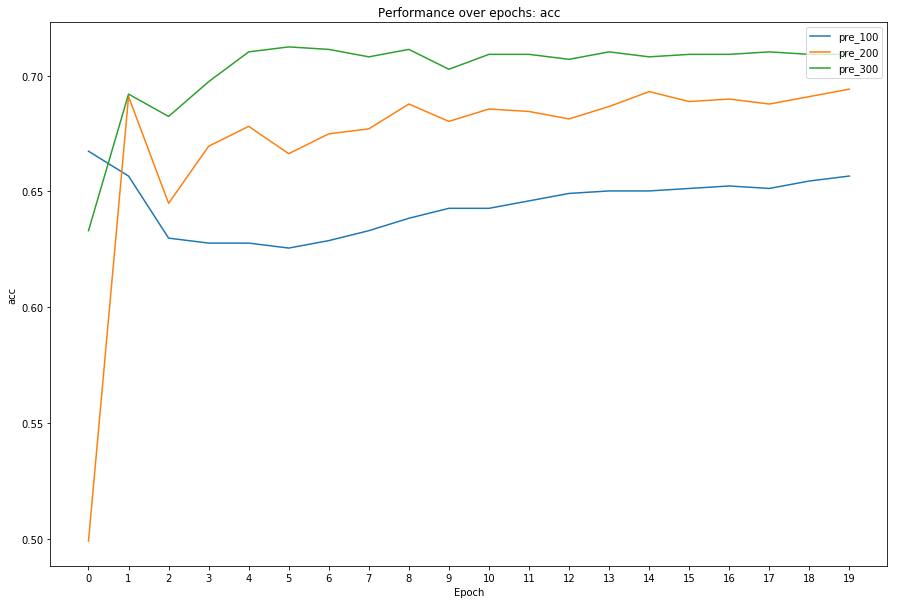

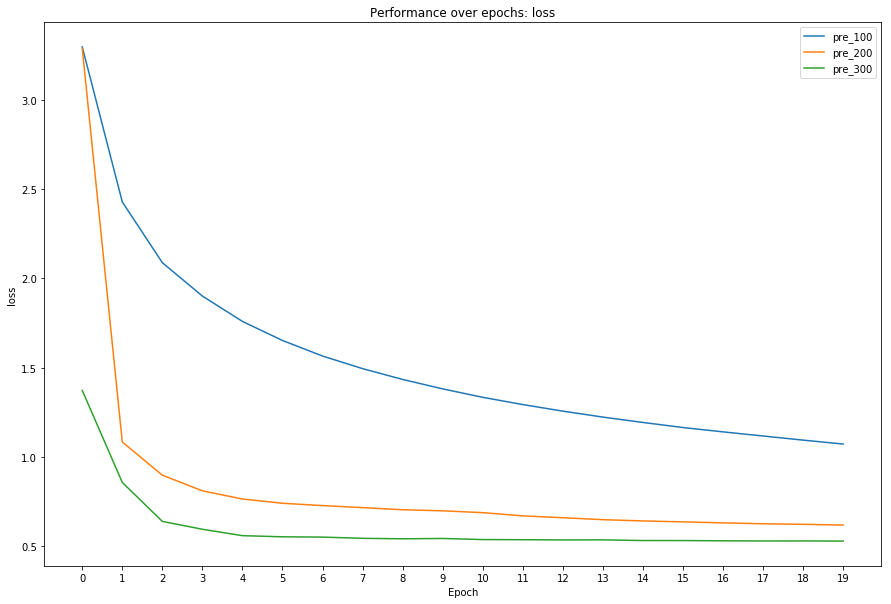

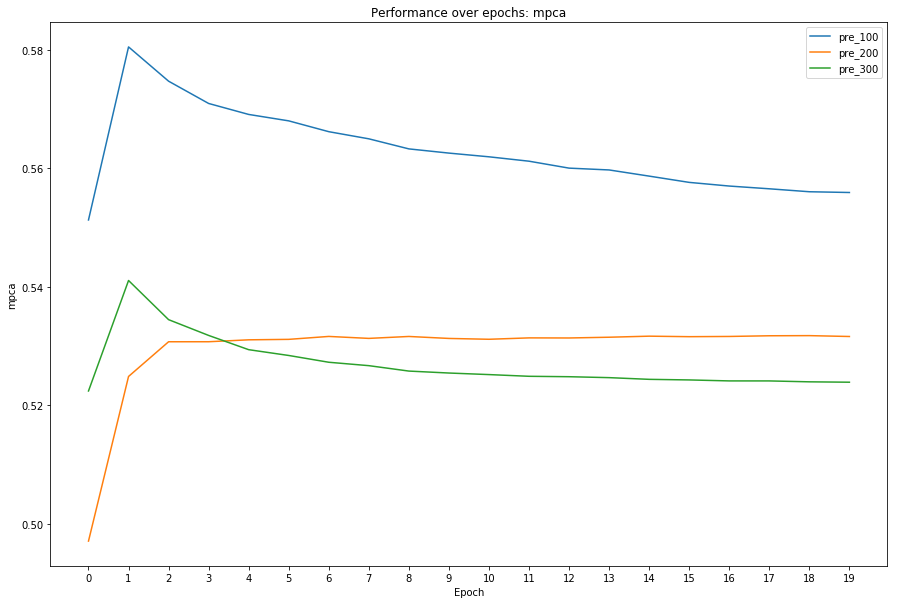

In [71]:
def plot_metric(metric):
    # combine all histories
    history = {'pre_100': pre_100_his[metric], 
               'pre_200': pre_200_his[metric], 
               'pre_300': pre_300_his[metric]}

    hist_df = tuple(history.values())
    hist_df = np.column_stack(hist_df)
    hist_df = pd.DataFrame(hist_df, columns=history.keys())

    # plot history
    fig, ax = plt.subplots(figsize=(15, 10))
    hist_df.plot(ax=ax)
    plt.title('Performance over epochs: {}'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.xticks(range(0, 20))
    plt.legend(loc='upper right')
    plt.show()

plot_metric('acc')
plot_metric('loss')
plot_metric('mpca')

In [ ]:
# pretrained 100
pre_100_his = run_in_duplicate(100, new_weights=False, trainable=False)

# pretrained 200
pre_200_his = run_in_duplicate(200, new_weights=False, trainable=False)

# pretrained 300
pre_300_his = run_in_duplicate(300, new_weights=False, trainable=False)

In [ ]:
# pretrained trainable 100
re_100_his = run_in_duplicate(100, new_weights=False, trainable=True)

# pretrained trainable 200
re_200_his = run_in_duplicate(200, new_weights=False, trainable=True)

# pretrained trainable 300
re_300_his = run_in_duplicate(300, new_weights=False, trainable=True)

In [ ]:
# untrained 100
un_100_his = run_in_duplicate(100, new_weights=True, trainable=True)

# untrained 200
un_200_his = run_in_duplicate(200, new_weights=True, trainable=True)

# untrained 300
un_300_his = run_in_duplicate(300, new_weights=True, trainable=True)

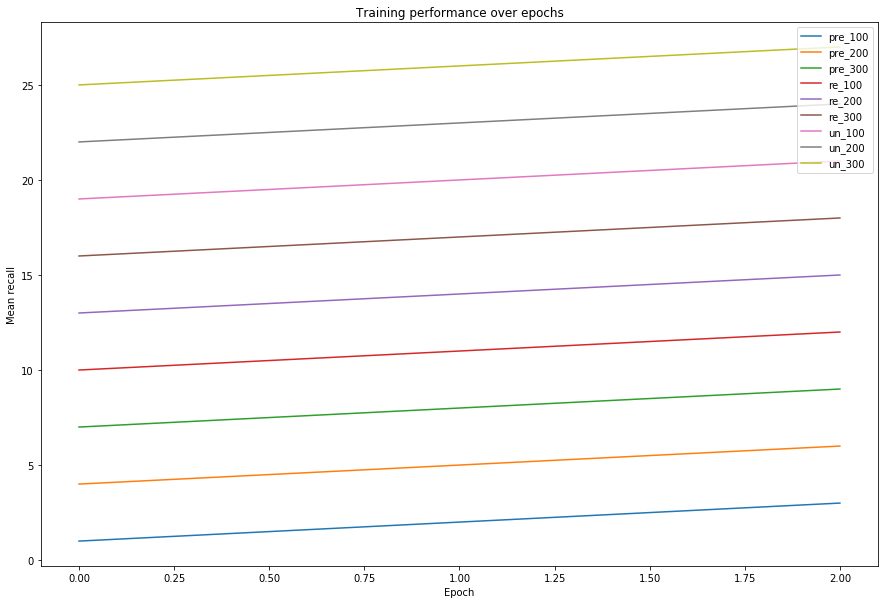

In [21]:
pre_100_his = np.array([1, 2, 3])
pre_200_his = np.array([4, 5, 6])
pre_300_his = np.array([7, 8, 9])
re_100_his = np.array([10, 11, 12])
re_200_his = np.array([13, 14, 15])
re_300_his = np.array([16, 17, 18])
un_100_his = np.array([19, 20, 21])
un_200_his = np.array([22, 23, 24])
un_300_his = np.array([25, 26, 27])

# combine all histories
histories = {'pre_100': pre_100_his, 
             'pre_200': pre_200_his, 
             'pre_300': pre_300_his, 
             're_100': re_100_his,
             're_200': re_200_his, 
             're_300': re_300_his, 
             'un_100': un_100_his, 
             'un_200': un_200_his, 
             'un_300': un_300_his}

hist_df = tuple(histories.values())
hist_df = np.column_stack(hist_df)
hist_df = pd.DataFrame(hist_df, columns=histories.keys())

# plot history
fig, ax = plt.subplots(figsize=(15, 10))
hist_df.plot(ax=ax)
plt.title('Training performance over epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean recall')
plt.legend(loc='upper right')
plt.show()